# A generational model of gun ownership and gun control

Allen Downey

[MIT License](https://en.wikipedia.org/wiki/MIT_License)

In [1]:
from __future__ import print_function, division

%matplotlib inline

import pandas as pd
import numpy as np

import thinkstats2
import thinkplot
import utils

import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

import matplotlib
matplotlib.rc('figure', figsize=(4, 3))

import seaborn as sns
sns.set(style='white', font_scale=1.5, context='talk')
RED, BLUE, GREEN, PURPLE, ORANGE, YELLOW = sns.color_palette('Set1')

from collections import Counter
from statsmodels.discrete.discrete_model import MNLogit
from statsmodels.discrete.discrete_model import Logit

## Loading and validation

Reading data from the [General Social Survey](https://gssdataexplorer.norc.org/projects/29853)

You can get my selected subset of variables from https://gssdataexplorer.norc.org/projects/41723#

In [2]:
gss = utils.ReadGss('gss_gun')
print(gss.shape)
gss.head()

(62466, 24)


,year,conrinc,cohort,ballot,wtssall,income,finrela,realinc,sex,homosex,...,age,race,srcbelt,polviews,natcrime,gunlaw,gun,gunage,gunnum,educ
0,1972,0.0,1949,0,0.4446,0,3,18951.0,2,0,...,23,1,3,0,0,1,0,0,0,16
1,1972,0.0,1902,0,0.8893,0,4,24366.0,1,0,...,70,1,3,0,0,1,0,0,0,10
2,1972,0.0,1924,0,0.8893,0,3,24366.0,2,0,...,48,1,3,0,0,1,0,0,0,12
3,1972,0.0,1945,0,0.8893,0,3,30458.0,2,0,...,27,1,3,0,0,1,0,0,0,17
4,1972,0.0,1911,0,0.8893,0,4,50763.0,2,0,...,61,1,3,0,0,1,0,0,0,12


In [3]:
def replace_invalid(df):
    df.gunlaw.replace([8, 9, 0], np.nan, inplace=True)
    df.owngun.replace([3, 8, 9, 0], np.nan, inplace=True)
    df.gun.replace([8, 9, 0], np.nan, inplace=True)
    df.natcrime.replace([8, 9, 0], np.nan, inplace=True)
    df.income.replace([0, 13, 98, 99], np.nan, inplace=True)
    df.realinc.replace([0], np.nan, inplace=True)                  # TODO: check this
    df.educ.replace([98,99], np.nan, inplace=True)
    df.polviews.replace([8, 9, 0], np.nan, inplace=True)
    df.age.replace([98, 99], np.nan, inplace=True)               # 89 means 89 or older
    df.hispanic.replace([98, 99, 0], np.nan, inplace=True)
    df.cohort.replace([9999], np.nan, inplace=True)

In [4]:
def numnull(series):
    return sum(series.isnull())

In [5]:
replace_invalid(gss)

### Variable `gunlaw`

Would you favor or oppose a law which would require a person to obtain a police permit before he or she could buy a gun?

https://gssdataexplorer.norc.org/projects/41723/variables/272/vshow

In [6]:
numnull(gss.gunlaw)

21994

In [7]:
utils.values(gss, 'gunlaw')

1.0    30936
2.0     9536
Name: gunlaw, dtype: int64

### Variable `owngun`

Do you happen to have in your home (IF HOUSE: or garage) any guns or revolvers?

https://gssdataexplorer.norc.org/projects/41723/variables/679/vshow

In [8]:
numnull(gss.owngun)

24826

In [9]:
utils.values(gss, 'owngun')

1.0    15122
2.0    22518
Name: owngun, dtype: int64

### Variable `gun`

Have you ever been threatened with a gun, or shot at? 

https://gssdataexplorer.norc.org/projects/41723/variables/661/vshow

In [10]:
numnull(gss.gun)

43138

In [11]:
utils.values(gss, 'gun')

1.0     3775
2.0    15553
Name: gun, dtype: int64

### Variable `natcrime`

We are faced with many problems in this country, none of which can be solved easily or inexpensively. I'm going to name some of these problems, and for each one I'd like you to name some of these problems, and for each one I'd like you to tell me whether you think we're spending too much money on it, too little money, or about the right amount. First (READ ITEM A) . . . are we spending too much, too little, or about the right amount on (ITEM)? 
E. Halting the rising crime rate

[Note: the wording of this question assumes that crime rates are rising!]

https://gssdataexplorer.norc.org/projects/41723/variables/185/vshow

In [12]:
numnull(gss.natcrime)

28064

In [13]:
utils.values(gss, 'natcrime')

1.0    23200
2.0     9099
3.0     2103
Name: natcrime, dtype: int64

### Variable `income`

In which of these groups did your total family income, from all sources, fall last year before taxes, that is?



In [14]:
varname = 'income'
numnull(gss[varname])

7961

In [15]:
utils.values(gss, varname)

1.0       762
2.0      1301
3.0      1253
4.0      1153
5.0      1267
6.0      1214
7.0      1268
8.0      2149
9.0      6354
10.0     4965
11.0     5047
12.0    27772
Name: income, dtype: int64

In [16]:
gss[varname].describe()

count    54505.000000
mean        10.036492
std          2.845831
min          1.000000
25%          9.000000
50%         12.000000
75%         12.000000
max         12.000000
Name: income, dtype: float64

### Variable `realinc`

Family income on 1972-2006 surveys in constant dollars (base = 1986)

https://gssdataexplorer.norc.org/variables/5198/vshow


In [17]:
varname = 'realinc'
numnull(gss[varname])

6325

In [18]:
gss[varname].describe()

count     56141.000000
mean      31636.199666
std       29402.370825
min         234.000000
25%       12080.625000
50%       24097.500000
75%       39022.500000
max      162607.000000
Name: realinc, dtype: float64

### Variable `educ`

A. What is the highest grade in elementary school or high school that (you/your father/ your mother/your [husband/wife]) finished and got credit for? CODE EXACT GRADE. 
B. IF FINISHED 9th-12th GRADE OR DK*: Did (you/he/she) ever get a high school diploma or a GED certificate? [SEE D BELOW.] [See REMARKS] 
C. Did (you/he/she) complete one or more years of college for credit--not including schooling such as business college, technical or vocational school? IF YES: How many years did (you/he/she) complete? 
Do you (Does [he/she]) have any college degrees? (IF YES: What degree or degrees?) CODE HIGHEST DEGREE EARNED.

https://gssdataexplorer.norc.org/projects/41723/variables/55/vshow


In [19]:
varname = 'educ'
numnull(gss[varname])

174

In [20]:
utils.values(gss, varname)

0.0       161
1.0        45
2.0       148
3.0       247
4.0       314
5.0       399
6.0       808
7.0       871
8.0      2689
9.0      2032
10.0     2815
11.0     3648
12.0    19006
13.0     5177
14.0     6847
15.0     2783
16.0     7925
17.0     1870
18.0     2265
19.0      875
20.0     1367
Name: educ, dtype: int64

### Variable `polviews`


A. We hear a lot of talk these days about liberals and conservatives. 
I'm going to show you a seven-point scale on which the political views that people might hold are arranged from extremely liberal--point 1--to extremely conservative--point 7. Where would you place yourself on this scale?

https://gssdataexplorer.norc.org/projects/41723/variables/178/vshow

In [21]:
varname = 'polviews'
numnull(gss[varname])

9385

In [22]:
utils.values(gss, varname)

1.0     1560
2.0     6236
3.0     6754
4.0    20515
5.0     8407
6.0     7876
7.0     1733
Name: polviews, dtype: int64

### Age 

https://gssdataexplorer.norc.org/projects/29853/variables/53/vshow

In [23]:
numnull(gss.age)

221

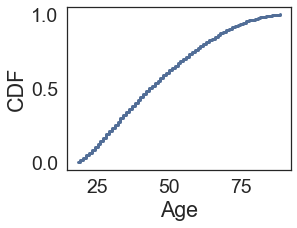

In [24]:
thinkplot.Cdf(thinkstats2.Cdf(gss.age))
thinkplot.Config(xlabel='Age', ylabel='CDF')

### Year of birth 

https://gssdataexplorer.norc.org/projects/29853/variables/5507/vshow

In [25]:
numnull(gss.cohort)

221

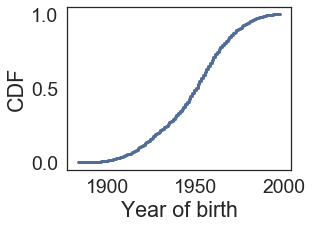

In [26]:
thinkplot.Cdf(thinkstats2.Cdf(gss.cohort))
thinkplot.Config(xlabel='Year of birth', ylabel='CDF')

### Sex 

https://gssdataexplorer.norc.org/projects/41723/variables/81/vshow

In [27]:
numnull(gss.sex)

0

In [28]:
utils.values(gss, 'sex')

1    27562
2    34904
Name: sex, dtype: int64

### Race

https://gssdataexplorer.norc.org/projects/41723/variables/82/vshow

CODE WITHOUT ASKING ONLY IF THERE IS NO DOUBT IN YOUR MIND. 
What race do you consider yourself? RECORD VERBATIM AND CODE.

In [29]:
numnull(gss.race)

0

In [30]:
utils.values(gss, 'race')

1    50340
2     8802
3     3324
Name: race, dtype: int64

### Hispanic 



In [31]:
numnull(gss.hispanic)

38149

In [32]:
utils.values(gss, 'hispanic')

1.0     21571
2.0      1661
3.0       346
4.0       115
5.0        91
6.0        52
7.0        14
8.0        18
9.0         3
10.0       25
11.0       38
15.0       63
16.0        1
20.0       27
21.0       32
22.0       37
23.0       13
24.0       12
25.0        3
30.0      121
31.0        2
35.0        7
40.0        5
41.0       21
42.0        1
45.0        3
46.0       12
47.0       13
50.0       10
Name: hispanic, dtype: int64

### srcbelt

C. SRC (SURVEY RESEARCH CENTER, UNIVERSITY OF MICHIGAN) NEW BELT CODE

https://gssdataexplorer.norc.org/projects/41723/variables/121/vshow

In [33]:
numnull(gss.srcbelt)

0

In [34]:
utils.values(gss, 'srcbelt')

1     5572
2     8670
3     7113
4     9348
5    23583
6     8180
Name: srcbelt, dtype: int64

### Make age and cohort groups

Group people into 5- and 10-year bins by birth year.

In [35]:
gss['cohort5'] = utils.RoundIntoBins(gss, 'cohort', 5, low=2) + 2.5

In [36]:
grouped_cohort = gss.groupby(['cohort5'])
counts = grouped_cohort.gunlaw.count()           # count cases where we have the dependent var
counts

cohort5
1884.5      15
1889.5      85
1894.5     216
1899.5     443
1904.5     722
1909.5    1089
1914.5    1500
1919.5    1837
1924.5    2145
1929.5    2146
1934.5    2328
1939.5    2616
1944.5    3336
1949.5    4254
1954.5    4150
1959.5    3717
1964.5    2935
1969.5    2230
1974.5    1644
1979.5    1266
1984.5     879
1989.5     560
1994.5     213
1999.5      14
2004.5     132
Name: gunlaw, dtype: int64

To avoid a final data point with a small sample size, I chose `low` to minimize the number of people in the last group, and I've lumped them in with the previous group.

In [37]:
gss.loc[gss.cohort5==1999.5, 'cohort5'] = 1994.5
gss.loc[gss.cohort5<1894, 'cohort5'] = 1894.5

In [38]:
grouped_cohort = gss.groupby(['cohort5'])
counts = grouped_cohort.gunlaw.count()
counts

cohort5
1894.5     316
1899.5     443
1904.5     722
1909.5    1089
1914.5    1500
1919.5    1837
1924.5    2145
1929.5    2146
1934.5    2328
1939.5    2616
1944.5    3336
1949.5    4254
1954.5    4150
1959.5    3717
1964.5    2935
1969.5    2230
1974.5    1644
1979.5    1266
1984.5     879
1989.5     560
1994.5     227
2004.5     132
Name: gunlaw, dtype: int64

In [39]:
gss['cohort10'] = utils.RoundIntoBins(gss, 'cohort', 10)

In [40]:
grouped_cohort = gss.groupby(['cohort10'])
counts = grouped_cohort.gunlaw.count()
counts

cohort10
1880.0      53
1890.0     502
1900.0    1563
1910.0    3024
1920.0    4212
1930.0    4703
1940.0    6929
1950.0    8212
1960.0    5721
1970.0    3278
1980.0    1750
1990.0     393
2000.0     132
Name: gunlaw, dtype: int64

Here's the number of respondents in each year.

In [41]:
utils.values(gss, 'year')

1972    1613
1973    1504
1974    1484
1975    1490
1976    1499
1977    1530
1978    1532
1980    1468
1982    1860
1983    1599
1984    1473
1985    1534
1986    1470
1987    1819
1988    1481
1989    1537
1990    1372
1991    1517
1993    1606
1994    2992
1996    2904
1998    2832
2000    2817
2002    2765
2004    2812
2006    4510
2008    2023
2010    2044
2012    1974
2014    2538
2016    2867
Name: year, dtype: int64

Group into 4 year intervals, chosen to get 2014 and 2016 into the last bin.

In [42]:
gss['year4'] = utils.RoundIntoBins(gss, 'year', 4, low=1970) + 1
utils.values(gss, 'year4')

1971    3117
1975    6003
1979    3000
1983    6466
1987    6307
1991    4495
1995    5896
1999    5649
2003    5577
2007    6533
2011    4018
2015    5405
Name: year4, dtype: int64

Group people into 5 and 3-year age groups.

In [43]:
gss['age5'] = utils.RoundIntoBins(gss, 'age', 5) + 2.5
utils.values(gss, 'age5')

17.5    1054
22.5    5283
27.5    6663
32.5    6784
37.5    6475
42.5    5924
47.5    5375
52.5    5007
57.5    4530
62.5    4047
67.5    3612
72.5    2955
77.5    2207
82.5    1381
87.5     948
92.5     221
Name: age5, dtype: int64

In [44]:
gss['age3'] = utils.RoundIntoBins(gss, 'age', 3, low=0) + 1.5
utils.values(gss, 'age3')

19.5    1924
22.5    3238
25.5    3815
28.5    4023
31.5    4094
34.5    4033
37.5    3951
40.5    3609
43.5    3496
46.5    3217
49.5    3178
52.5    3019
55.5    2817
58.5    2681
61.5    2538
64.5    2289
67.5    2184
70.5    1913
73.5    1690
76.5    1418
79.5    1114
82.5     840
85.5     573
88.5     591
91.5     221
Name: age3, dtype: int64

### Make booleans

In [45]:
def copy_nan(df, varname, newvar):
    df.loc[df[varname].isnull(), newvar] = np.nan

In [46]:
def make_boolean(df, varname, values, newvar):
    """Make a boolean variable.
    
    df: DataFrame
    varname: name of base variable
    values: sequence of values for varname
    newvar: name of new variable (recode)
    """
    #assert numnull(df[varname]) == 0
    df[newvar] = df[varname].isin(values)
    copy_nan(df, varname, newvar)

In [47]:
def make_booleans(df):
    df['cohort10'] = utils.RoundIntoBins(df, 'cohort', 10)
    make_boolean(df, 'cohort10', [1920], 'twenties')
    make_boolean(df, 'cohort10', [1930], 'thirties')
    make_boolean(df, 'cohort10', [1940], 'forties')
    make_boolean(df, 'cohort10', [1950], 'fifties')
    make_boolean(df, 'cohort10', [1960], 'sixties')
    make_boolean(df, 'cohort10', [1970], 'seventies')
    make_boolean(df, 'cohort10', [1980], 'eighties')
    make_boolean(df, 'cohort10', [1990], 'nineties')
    make_boolean(df, 'gunlaw', [1.0], 'favor')
    make_boolean(df, 'owngun', [1.0], 'gunhome')
    make_boolean(df, 'gun', [1.0], 'threatened')
    make_boolean(df, 'natcrime', [1.0], 'spendcrime')
    make_boolean(df, 'income', [12], 'topincome')
    make_boolean(df, 'income', [1,2,3,4,5,6,7,8], 'lowincome')
    make_boolean(df, 'polviews', [1,2,3], 'liberal')
    make_boolean(df, 'polviews', [4], 'moderate')
    make_boolean(df, 'polviews', [6,7,8], 'conservative')
    make_boolean(df, 'sex', [2], 'female')
    make_boolean(df, 'hispanic', [2], 'ishisp')
    make_boolean(df, 'race', [2], 'black')
    make_boolean(df, 'race', [3], 'otherrace')
    make_boolean(df, 'srcbelt', [1,2,5], 'urban')
    make_boolean(df, 'srcbelt', [3,4], 'suburban')
    make_boolean(df, 'srcbelt', [6], 'rural')

    df['college'] = df['educ'] >= 13 
    copy_nan(df, 'educ', 'college')
    
    per25 = df['realinc'].quantile(0.25)
    df['lowrealinc'] = df['realinc'] <= per25 
    copy_nan(df, 'realinc', 'lowrealinc')

    per75 = df['realinc'].quantile(0.75)
    df['highrealinc'] = df['realinc'] >= per75 
    copy_nan(df, 'realinc', 'highrealinc')

make_booleans(gss)

### Resample

In [48]:
sample = utils.ResampleByYear(gss).copy()
sample.shape

(62466, 56)

In [49]:
utils.values(sample, 'twenties')

0.0    56493
1.0     5973
Name: twenties, dtype: int64

In [50]:
utils.values(sample, 'thirties')

0.0    55554
1.0     6912
Name: thirties, dtype: int64

In [51]:
utils.values(sample, 'forties')

0.0    52264
1.0    10202
Name: forties, dtype: int64

In [52]:
utils.values(sample, 'fifties')

0.0    49483
1.0    12983
Name: fifties, dtype: int64

In [53]:
utils.values(sample, 'sixties')

0.0    52560
1.0     9906
Name: sixties, dtype: int64

In [54]:
utils.values(sample, 'seventies')

0.0    56336
1.0     6130
Name: seventies, dtype: int64

In [55]:
utils.values(sample, 'eighties')

0.0    59054
1.0     3412
Name: eighties, dtype: int64

In [56]:
utils.values(sample, 'nineties')

0.0    61567
1.0      899
Name: nineties, dtype: int64

In [57]:
utils.values(sample, 'favor')

0.0     9770
1.0    30847
Name: favor, dtype: int64

In [58]:
utils.values(sample, 'gunhome')

0.0    21465
1.0    16243
Name: gunhome, dtype: int64

In [59]:
utils.values(sample, 'threatened')

0.0    15539
1.0     3737
Name: threatened, dtype: int64

In [60]:
utils.values(sample, 'spendcrime')

0.0    11145
1.0    23434
Name: spendcrime, dtype: int64

In [61]:
utils.values(sample, 'topincome')

0.0    24112
1.0    29862
Name: topincome, dtype: int64

In [62]:
utils.values(sample, 'lowincome')

0.0    45400
1.0     8574
Name: lowincome, dtype: int64

In [63]:
utils.values(sample, 'lowrealinc')

0.0    44023
1.0    11609
Name: lowrealinc, dtype: int64

In [64]:
utils.values(sample, 'highrealinc')

0.0    39102
1.0    16530
Name: highrealinc, dtype: int64

In [65]:
utils.values(sample, 'liberal')

0.0    39009
1.0    14165
Name: liberal, dtype: int64

In [66]:
utils.values(sample, 'moderate')

0.0    32720
1.0    20454
Name: moderate, dtype: int64

In [67]:
utils.values(sample, 'conservative')

0.0    43338
1.0     9836
Name: conservative, dtype: int64

In [68]:
utils.values(sample, 'female')

0.0    28437
1.0    34029
Name: female, dtype: int64

In [69]:
utils.values(sample, 'ishisp')

0.0    22493
1.0     1822
Name: ishisp, dtype: int64

In [70]:
utils.values(sample, 'black')

0.0    54077
1.0     8389
Name: black, dtype: int64

In [71]:
utils.values(sample, 'otherrace')

0.0    58756
1.0     3710
Name: otherrace, dtype: int64

In [72]:
utils.values(sample, 'urban')

0.0    25375
1.0    37091
Name: urban, dtype: int64

In [73]:
utils.values(sample, 'suburban')

0.0    45261
1.0    17205
Name: suburban, dtype: int64

In [74]:
utils.values(sample, 'rural')

0.0    54296
1.0     8170
Name: rural, dtype: int64

In [75]:
utils.values(sample, 'college')

0.0    33432
1.0    28867
Name: college, dtype: int64

### Look at trends

In [76]:
def plot_series(grouped, varname, **options):
    series = grouped[varname].mean() * 100
    thinkplot.plot(series.dropna(), **options, label=varname)
    thinkplot.config(xlabel='Year of survey', 
                     ylabel='Percent',
                     xlim=[1971, 2017])

In [77]:
grouped_year4 = sample.groupby('year4')

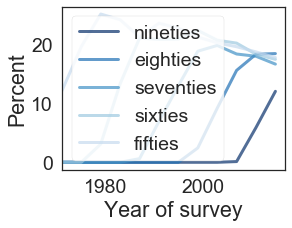

In [78]:
plot_series(grouped_year4, 'nineties')
plot_series(grouped_year4, 'eighties')
plot_series(grouped_year4, 'seventies')
plot_series(grouped_year4, 'sixties')
plot_series(grouped_year4, 'fifties')

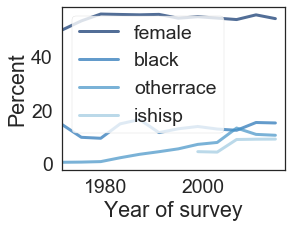

In [79]:
plot_series(grouped_year4, 'female')
plot_series(grouped_year4, 'black')
plot_series(grouped_year4, 'otherrace')
plot_series(grouped_year4, 'ishisp')

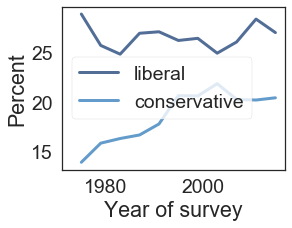

In [80]:
plot_series(grouped_year4, 'liberal')
plot_series(grouped_year4, 'conservative')

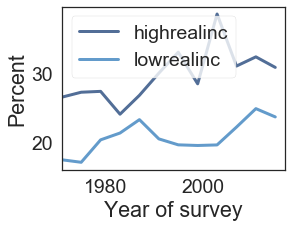

In [81]:
plot_series(grouped_year4, 'highrealinc')
plot_series(grouped_year4, 'lowrealinc')

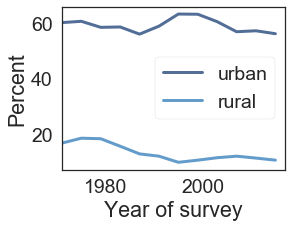

In [82]:
plot_series(grouped_year4, 'urban')
plot_series(grouped_year4, 'rural')

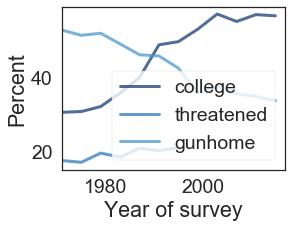

In [83]:
plot_series(grouped_year4, 'college')
plot_series(grouped_year4, 'threatened')
plot_series(grouped_year4, 'gunhome')

### Fill missing values

In [84]:
def fill_missing_column(df, colname):
    """Fills missing values of the given column.

    df: DataFrame
    colname: string
    """
    null = df[df[colname].isnull()]

    print(colname, len(null))

    valid = df[colname].dropna()
    fill = valid.sample(len(null), replace=True)
    fill.index = null.index

    df[colname].fillna(fill, inplace=True)

In [85]:
def fill_age(df):
    """Fills age based on year and cohort.
    
    df: DataFrame
    """
    colname = 'age'
    null = df[df[colname].isnull()]

    print('age', len(null))
    
    fill = df.year - df.cohort

    df[colname].fillna(fill, inplace=True)

In [86]:
def fill_all_missing(df):
    varnames = ['year', 'cohort', 'owngun', 'gun', 'natcrime', 'income', 'realinc', 'educ',
                'polviews', 'sex', 'race', 'hispanic', 'srcbelt']
    for varname in varnames:
        fill_missing_column(df, varname)
    fill_age(df)

In [87]:
fill_all_missing(sample)

year 0
cohort 188
owngun 24758
gun 43190
natcrime 27887
income 8492
realinc 6834
educ 167
polviews 9292
sex 0
race 0
hispanic 38151
srcbelt 0
age 188


After filling, we have to make booleans again.

In [88]:
make_booleans(sample)

### Center cohort, age, and year.

In [89]:
def center_factors(df):
    """Center factors around their means.
    
    Add centered factors to make the coeffients
    of the model easier to interpret.
    
    df: DataFrame
    """
    df['ones'] = np.ones_like(df.cohort)
    df['c'] = df.cohort - 1966
    df['a'] = df.age - 47
    df['y'] = df.year - 1990
    
    # also add quadratic factors and interaction term
    df['c2'] = df.c**2
    df['a2'] = df.a**2
    df['y2'] = df.y**2
    df['ac'] = df.a * df.c

In [90]:
center_factors(sample)

### Run logistic models



Drop records if we don't have the dependent variable.

In [91]:
subset = sample.dropna(subset=['gunlaw'])
subset.shape

(40617, 64)

How many records did we lose?

In [92]:
sample.shape[0] - subset.shape[0]

21849

In [93]:
subset.head()

,year,conrinc,cohort,ballot,wtssall,income,finrela,realinc,sex,homosex,...,lowrealinc,highrealinc,ones,c,a,y,c2,a2,y2,ac
0,1972,0.0,1918.0,0,0.8893,12.0,3,8122.00,2,0,...,1.0,0.0,1.0,-48.0,7.0,-18,2304.0,49.0,324,-336.0
1,1972,0.0,1912.0,0,0.8893,12.0,3,13537.00,1,0,...,1.0,0.0,1.0,-54.0,13.0,-18,2916.0,169.0,324,-702.0
2,1972,0.0,1953.0,0,1.3339,12.0,3,46901.25,2,0,...,0.0,1.0,1.0,-13.0,-28.0,-18,169.0,784.0,324,364.0
3,1972,0.0,1931.0,0,0.8893,11.0,4,50763.00,2,0,...,0.0,1.0,1.0,-35.0,-6.0,-18,1225.0,36.0,324,210.0
4,1972,0.0,1906.0,0,0.8893,10.0,3,13537.00,1,0,...,1.0,0.0,1.0,-60.0,19.0,-18,3600.0,361.0,324,-1140.0


In [94]:
sample.columns

Index(['year', 'conrinc', 'cohort', 'ballot', 'wtssall', 'income', 'finrela',
       'realinc', 'sex', 'homosex', 'hispanic', 'rowngun', 'owngun', 'id_',
       'age', 'race', 'srcbelt', 'polviews', 'natcrime', 'gunlaw', 'gun',
       'gunage', 'gunnum', 'educ', 'cohort5', 'cohort10', 'year4', 'age5',
       'age3', 'twenties', 'thirties', 'forties', 'fifties', 'sixties',
       'seventies', 'eighties', 'nineties', 'favor', 'gunhome', 'threatened',
       'spendcrime', 'topincome', 'lowincome', 'liberal', 'moderate',
       'conservative', 'female', 'ishisp', 'black', 'otherrace', 'urban',
       'suburban', 'rural', 'college', 'lowrealinc', 'highrealinc', 'ones',
       'c', 'a', 'y', 'c2', 'a2', 'y2', 'ac'],
      dtype='object')

In [95]:
varnames = ['nineties', 'eighties', 'seventies', 'fifties', 'forties', 'thirties', 'twenties',
            'female', 'black', 'otherrace', 'ishisp', 'conservative', 'liberal', 'lowrealinc', 'highrealinc',
            'college', 'urban', 'rural', 'threatened', 'gunhome']

all_varnames = varnames + ['y', 'y2', 'favor']

In [96]:
for varname in varnames:
    print(varname, sum(sample[varname].isnull()))

nineties 0
eighties 0
seventies 0
fifties 0
forties 0
thirties 0
twenties 0
female 0
black 0
otherrace 0
ishisp 0
conservative 0
liberal 0
lowrealinc 0
highrealinc 0
college 0
urban 0
rural 0
threatened 0
gunhome 0


Select just the columns we need

In [97]:
data = sample[all_varnames]
data.shape

(62466, 23)

In [98]:
formula = ('favor ~ y + y2 + nineties + eighties + seventies + fifties + forties + thirties + twenties + '
           'female + black + otherrace + ishisp + conservative + liberal + lowrealinc + highrealinc + ' 
           'college + urban + rural + threatened + gunhome')
model = smf.logit(formula, data=data).fit()
model.summary()

Optimization terminated successfully.
         Current function value: 0.510309
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  favor   No. Observations:                40617
Model:                          Logit   Df Residuals:                    40594
Method:                           MLE   Df Model:                           22
Date:                Tue, 13 Mar 2018   Pseudo R-squ.:                 0.07503
Time:                        17:31:29   Log-Likelihood:                -20727.
converged:                       True   LL-Null:                       -22408.
                                        LLR p-value:                     0.000
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        1.5963      0.045     35.211      0.000       1.507       1.685
y                0.0068      0.001      6.105      0.000       0.005       0.009
y2              -0.0008   7.53e-05    -10.510      0.000      -0.001      -0.001
nineties        -0.5923      0.105     -5.623      0.000      -0.799      -0.386
eighties        -0.2826      0.065     -4.356      0.000      -0.410      -0.155
seventies       -0.0762      0.051     -1.487      0.137      -0.177       0.024
fifties         -0.0090      0.037     -0.245      0.806      -0.081       0.063
forties         -0.0082      0.039     -0.212      0.832      -0.084       0.068
thirties        -0.0716      0.042     -1.698      0.090      -0.154       0.011
twenties        -0.0080      0.045     -0.180      0.857      -0.095       0.079
female           0.6844      0.025     27.803      0.000       0.636       0.733
black            0.2824      0.039      7.227      0.000       0.206       0.359
otherrace        0.4431      0.066      6.762      0.000       0.315       0.572
ishisp           0.0013      0.047      0.027      0.978      -0.091       0.093
conservative    -0.3207      0.031    -10.362      0.000      -0.381      -0.260
liberal          0.2386      0.030      7.892      0.000       0.179       0.298
lowrealinc      -0.0992      0.031     -3.208      0.001      -0.160      -0.039
highrealinc      0.0763      0.031      2.499      0.012       0.016       0.136
college          0.0842      0.026      3.202      0.001       0.033       0.136
urban           -0.2753      0.030     -9.093      0.000      -0.335      -0.216
rural           -0.4663      0.041    -11.460      0.000      -0.546      -0.387
threatened      -0.0679      0.030     -2.248      0.025      -0.127      -0.009
gunhome         -0.8777      0.026    -34.269      0.000      -0.928      -0.827
================================================================================
"""

In [99]:
y = 2016 - 1990
y2 = y**2

d = dict(y=y, y2=y2)
for varname in varnames:
    d[varname] = 0

s = pd.Series(d)
s

black             0
college           0
conservative      0
eighties          0
female            0
fifties           0
forties           0
gunhome           0
highrealinc       0
ishisp            0
liberal           0
lowrealinc        0
nineties          0
otherrace         0
rural             0
seventies         0
thirties          0
threatened        0
twenties          0
urban             0
y                26
y2              676
dtype: int64

In [100]:
df_pred = pd.DataFrame(columns=sample.columns)
df_pred

,year,conrinc,cohort,ballot,wtssall,income,finrela,realinc,sex,homosex,...,lowrealinc,highrealinc,ones,c,a,y,c2,a2,y2,ac


In [119]:
df_pred.loc['base'] = s

for varname in varnames:
    df_pred.loc[varname] = s
    df_pred.loc[varname, varname] = 1
    
df_pred.loc['yminus10'] = s
df_pred.loc['yminus10', 'y'] -= 10
df_pred.loc['yminus10', 'y2'] = df_pred.loc['yminus10', 'y']**2

df_pred.loc['yminus20'] = s
df_pred.loc['yminus20', 'y'] -= 20
df_pred.loc['yminus20', 'y2'] = df_pred.loc['yminus20', 'y']**2

df_pred.loc['yminus30'] = s
df_pred.loc['yminus30', 'y'] -= 30
df_pred.loc['yminus30', 'y2'] = df_pred.loc['yminus30', 'y']**2
    
df_pred.loc['yminus40'] = s
df_pred.loc['yminus40', 'y'] -= 40
df_pred.loc['yminus40', 'y2'] = df_pred.loc['yminus40', 'y']**2
    
df_pred.loc[:, all_varnames]

,nineties,eighties,seventies,fifties,forties,thirties,twenties,female,black,otherrace,...,lowrealinc,highrealinc,college,urban,rural,threatened,gunhome,y,y2,favor
base,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,26.0,676.0,NaN
nineties,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,26.0,676.0,NaN
eighties,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,26.0,676.0,NaN
seventies,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,26.0,676.0,NaN
fifties,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,26.0,676.0,NaN
forties,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,26.0,676.0,NaN
thirties,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,26.0,676.0,NaN
twenties,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,26.0,676.0,NaN
female,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,26.0,676.0,NaN
black,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,26.0,676.0,NaN


In [120]:
pred = model.predict(df_pred) * 100
pred

base            77.528642
nineties        65.614292
eighties        72.227259
seventies       76.173836
fifties         77.371279
forties         77.385489
thirties        76.256421
twenties        77.388284
female          87.244656
black           82.066423
otherrace       84.310411
ishisp          77.550800
conservative    71.456653
liberal         81.412515
lowrealinc      75.753145
highrealinc     78.830237
college         78.961499
urban           72.374001
rural           68.396656
threatened      76.324172
gunhome         58.921952
yminus10        81.797042
yminus20        83.322671
yminus30        82.584284
yminus40        79.347240
dtype: float64

In [121]:
pred - pred['base']

base             0.000000
nineties       -11.914350
eighties        -5.301383
seventies       -1.354806
fifties         -0.157363
forties         -0.143153
thirties        -1.272221
twenties        -0.140358
female           9.716014
black            4.537781
otherrace        6.781769
ishisp           0.022158
conservative    -6.071989
liberal          3.883873
lowrealinc      -1.775497
highrealinc      1.301595
college          1.432856
urban           -5.154641
rural           -9.131986
threatened      -1.204470
gunhome        -18.606690
yminus10         4.268400
yminus20         5.794029
yminus30         5.055642
yminus40         1.818598
dtype: float64

In [122]:
def predict_favor(df, model):
    probs = model.predict(df)
    bools = np.random.random(len(probs)) < probs
    return bools.dropna().mean() * 100

In [123]:
predict_favor(data, model)

76.460794672301731

In [124]:
data.favor.mean()

0.7594603244946697

In [125]:
for name, group in grouped_year4:
    retro = predict_favor(group, model)
    actual = group.favor.mean() * 100
    print(name, actual, retro)

1971 73.88724035608308 71.0940006416
1975 72.86900525334688 72.297184741
1979 69.3062368605466 74.2666666667
1983 72.87066246056783 76.5852149706
1987 74.82740308019117 78.1829713017
1991 80.30664395229982 78.4872080089
1995 80.11233086545826 79.0027137042
1999 82.94552422666301 79.1290493893
2003 80.02283105022832 77.8913394298
2007 79.98798076923077 77.4223174652
2011 73.72319688109161 74.8133399701
2015 71.2412831241283 73.4320074006


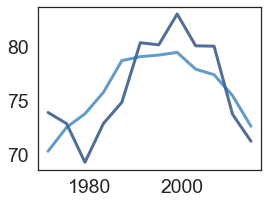

In [126]:
actual = pd.Series([])
retro = pd.Series([])
for name, group in grouped_year4:
    retro[name] = predict_favor(group, model)
    actual[name] = group.favor.mean() * 100

thinkplot.plot(actual.index, actual)
thinkplot.plot(retro.index, retro)

In [109]:
stop

NameError: name 'stop' is not defined

### Run counterfactuals

In [ ]:
# may not need this any more, since sample is a copy
counterfact = sample.copy()

In [ ]:
def flip(df, varname, val, new_val, prob):
    """Changes the value of a variable for a random sample of rows.
    
    Selects each row where varname==val with probability prob, and
    replaces val with new_val.
    
    df: DataFrame
    varname: string
    val: old value
    new_val: new value
    prob: probability of flipping
    """
    assert(0 < prob < 1)
    print('flip', val, new_val, prob)
    
    # get indices of the rows that match val
    indices = np.flatnonzero(df[varname] == val)
    print(len(indices) * prob)
    
    # flip a coin for each selected row
    cond = np.random.random(len(indices)) < prob

    # get indices of the rows that will flip
    flippers = indices[cond]
    print(len(flippers))
    #print((df.loc[flippers, varname] == val).mean())
    
    # assign the new val to the selected rows
    labels = df.index[flippers]
    df.loc[labels, varname] = new_val

In [ ]:
counterfact.college.value_counts()

In [ ]:
flip(counterfact, 'college', 1, 0, 0.1)

In [ ]:
counterfact.college.value_counts()

In [ ]:
def adjust_prob(df, varname, desired):
    """
    
    Must be a 0,1 boolean
    """
    actual = df[varname].mean()
    diff = desired - actual
    print(actual, diff)
    if diff > 0:
        prob = diff / (1-actual)
        flip(df, varname, 0, 1, prob)
    elif diff < 0:
        prob = -diff / actual
        flip(df, varname, 1, 0, prob)

In [ ]:
counterfact.college.value_counts()

In [ ]:
adjust_prob(counterfact, 'college', 0.9)

In [ ]:
counterfact.college.value_counts()

In [ ]:
counterfact.college.mean()

In [ ]:
def make_counterfactual(grouped, varname, prob):
    for name, group in grouped:
        print(name, group[varname].mean())
        adjust_prob(group, varname, prob)
        print(name, group[varname].mean())

In [ ]:
grouped_year4 = counterfact.groupby('year4')
grouped_year4.black.mean()

In [ ]:
prob = grouped_year4.black.mean()[1975]
prob

In [ ]:
make_counterfactual(grouped_year4, 'black', prob)


In [ ]:
predict_favor(counterfact, model)

In [ ]:
stop

## Favor gunlaw

In [ ]:
def make_series(grouped, varname):
    """Compute the percentage in each category.
    
    grouped: GroupBy object
    varname: string column name
    
    returns:  Series
    """
    return grouped[varname].mean() * 100

In [ ]:
def plot_series(series, **options):
    """Plots Series objects.
    
    series: Series
    """
    thinkplot.plot(series.dropna(), **options)

In [ ]:
def plot_gunlaw(grouped):
    """.
    
    grouped:
    """
    varnames = ['favor']
    colors = [BLUE]
    labels = ['Favor']
    series_seq = make_series_seq(grouped, varnames)
    plot_series_seq(series_seq, colors, labels)

Plot the percentage in each religious group as a function of survey year.

In [ ]:
grouped_year = sample.groupby('year')
favor = make_series(grouped_year, 'favor')
favor

In [ ]:
plot_series(favor, color=BLUE, label='favor')
thinkplot.config(xlabel='Year of survey', 
                 ylabel='Percent',
                 xlim=[1971, 2017])

In [ ]:
crime = make_series(grouped_year, 'crime')
crime

In [ ]:
plot_series(crime.loc[1984:], color=RED, label='crime')
thinkplot.config(xlabel='Year of survey', 
                 ylabel='Percent',
                 xlim=[1971, 2017])

In [ ]:
plot_series(favor, color=BLUE, label='favor')
plot_series(crime.loc[1984:], color=RED, label='crime')
thinkplot.config(title='Support for gun control and concern about crime',
                 xlabel='Year of survey', 
                 ylabel='Percent',
                 xlim=[1971, 2017])

In [ ]:
grouped_age = sample.groupby(['age_group'])

In [ ]:
plot_gunlaw(grouped_age)
thinkplot.config(xlabel='Age', ylabel='Percent')

Plot the percentage in favor of gun permits as a function of birth cohort.

In [ ]:
grouped_cohort = sample.groupby(['cohort5'])

In [ ]:
heri = pd.read_csv('heri_gun_control.csv')

In [ ]:
heri.year

In [ ]:
heri = pd.read_csv('heri_gun_control.csv')
thinkplot.plot(heri.year, heri.agree, color=ORANGE)

In [ ]:
plot_gunlaw(grouped_cohort)
thinkplot.plot(heri.yearm18, heri.agree, color=ORANGE, label='CIRP')
thinkplot.config(xlabel='Year of birth', ylabel='Percent')

## Logistic models

In [ ]:
def make_logit_model(df, var, factors):
    """Fit a logistic regression model.
    
    df: DataFrame
    var: string name of dependent variable
    factors: list of string names for factorscen
    
    returns: Logit model
    """
    # TODO: investigate the missing=drop option
    nonull = df.dropna(subset=factors+[var])
    y = nonull[var].values
    X = nonull[factors].values
    return Logit(y, X).fit(disp=False, full_output=False)

In [ ]:
factors = ['ones', 'a', 'c', 'a2', 'c2', 'ac']
factors = ['a', 'a2', 'nineties', 'eighties', 'seventies',
           'sixties', 'fifties', 'forties', 'thirties', 'twenties']
model = make_logit_model(sample, 'favor', factors)

In [ ]:
def predict_logit_model(age, model, year, factors):
    """Make a single-year prediction.
    
    age: Series of ages to simulate
    model: Logit model
    year: year to make a prediction for
    factors: list of string names for factors
    
    returns: Series that maps index to percentage
    """
    # resample the ages
    n = len(age)
    age = np.random.choice(age, n, replace=True)
    
    # compute cohort
    cohort = year - age
    df = pd.DataFrame(dict(cohort=cohort, age=age))
    center_factors(df)
    
    # compute probabilities in each category for each respondent
    X = df[factors].values
    pred = model.predict(X)
    
    # toss a weighted coin for each respondent
    choices = np.random.random(n) <= pred

    # return the percentage in favor
    return choices.mean() * 100

In [ ]:
age = sample.loc[sample.year==2016, 'age']

In [ ]:
predict_logit_model(age, model, 1976, factors)

In [ ]:
predict_logit_model(age, model, 2016, factors)

In [ ]:
predict_logit_model(age, model, 2026, factors)

In [ ]:
predict_logit_model(age, model, 2036, factors)

In [ ]:
def make_pred(df, var, varnames, years, factors):
    """Generate predictions from multinomial model.
    
    df: DataFrame of respondents
    var: dependent variable
    varnames: list of string variable names
    years: sequence of years to generate predictions for
    factors: list of string factor names for the model
    
    returns: DataFrame that maps from index to predicted values
    """ 
    model = make_logit_model(df, var, factors)
    age = df.loc[df.year==2016, 'age']

    pred = pd.DataFrame(columns=varnames)
    for year in years:
        pred.loc[year] = predict_logit_model(age, model, year, factors)
    return pred

In [ ]:
def plot_pred(df, pred, varnames, colors, alpha=0.2):
    """Plots predictions from multinomial model.
    
    pred: DataFrame with one column per variable
    varnames: list of string variable names
    colors: list of string colors
    alpha: numerical transparency
    """
    series_seq = [pred[var] for var in varnames]
    for series, color in zip(series_seq, colors):
        thinkplot.plot(series, color=color, alpha=alpha)
    thinkplot.config(xlabel='Year of survey', loc='upper right')

In [ ]:
var = 'favor'
varnames = ['favor']
years = np.arange(1970, 2038)
factors = ['ones', 'a', 'c']
colors = [BLUE]

pred = make_pred(sample, var, varnames, years, factors)
plot_pred(sample, pred, varnames, colors)
plot_gunlaw(grouped_year)
thinkplot.config(xlim=[1971, 2038])

In [ ]:
var = 'favor'
varnames = ['favor']
years = np.arange(1970, 2038)
factors = ['ones', 'a', 'c', 'a2', 'c2', 'ac']
index = ['favor']
colors = [BLUE]

pred = make_pred(sample, var, varnames, years, factors)
plot_pred(sample, pred, varnames, colors)
plot_gunlaw(grouped_year)
thinkplot.config(xlim=[1971, 2038])

In [ ]:
var = 'favor'
varnames = ['favor']
years = np.arange(1970, 2038)
factors = ['a', 'a2', 'nineties', 'eighties', 'seventies',
           'sixties', 'fifties', 'forties', 'thirties', 'twenties']
index = ['favor']
colors = [BLUE]

pred = make_pred(sample, var, varnames, years, factors)
plot_pred(sample, pred, varnames, colors)
plot_gunlaw(grouped_year)
thinkplot.config(xlim=[1971, 2038])

## Resampling

In [ ]:
def make_series_df(grouped, varnames):
    """Compute the percentage in each category.
    
    grouped: GroupBy object with one-hots for each category
    varnames: list of string column names
    
    returns: DataFrame
    """
    df = pd.DataFrame(columns=varnames)
    for var in varnames:
        df[var] = grouped[var].mean() * 100
    return df

In [ ]:
def percentile_rows(series_seq, ps):
    """Computes percentiles from aligned series.
    
    series_seq: list of sequences
    ps: cumulative probabilities
    
    returns: Series of x-values, NumPy array with selected rows
    """
    df = pd.concat(series_seq, axis=1).dropna()
    xs = df.index
    array = df.values.transpose()
    array = np.sort(array, axis=0)
    nrows, ncols = array.shape
    indices = (ps * nrows).astype(int)
    rows = array[indices]
    return xs, rows

In [ ]:
def plot_percentiles(dfs, varnames, colors, labels, plot=True, fill=True, alpha=0.2):
    """Plots 90% CI and median.
    
    dfs: list of DataFrames
    varnames: list of string variable names
    colors: list of string colors
    labels: list of string labels
    plot: boolean, whether to plot the median
    fill: boolean, whether to plot the CI
    """
    ps = np.array([0.05, 0.5, 0.95])

    for var, color, label in zip(varnames, colors, labels):
        series_seq = [df[var] for df in dfs]
        xs, rows = percentile_rows(series_seq, ps)
        if fill:
            thinkplot.fill_between(xs, rows[0], rows[2], color=color, alpha=alpha)
        if plot:
            thinkplot.plot(xs, rows[1], color=color, label=label)

In [ ]:
def run_data(df, groupvar, varnames, iters=11):
    """Resample and extract data.
    
    df: DataFrame
    groupvar: string variable to group by
    varnames: list of string variable names
    iters: number of resamples
    """
    def run():
        sample = utils.ResampleByYear(df)
        grouped_year = sample.groupby([groupvar])
        return make_series_df(grouped_year, varnames)

    dfs = [run() for _ in range(iters)]
    return dfs

In [ ]:
def run_model(df, var, varnames, years, iters=11):
    """Resample and make predictions.
    
    df: DataFrame
    var: string variable name to model
    varnames: list of string variable names
    years: list of years to predict
    iters: number of resamples
    
    returns: list of DataFrames
    """
    factors = ['ones', 'a', 'c', 'a2', 'c2', 'ac']
    factors = ['a', 'a2', 'nineties', 'eighties', 'seventies',
               'sixties', 'fifties', 'forties', 'thirties', 'twenties']

    def run():
        sample = utils.ResampleByYear(df)
        return make_pred(sample, var, varnames, years, factors)

    dfs = [run() for _ in range(iters)]
    return dfs

## Favor gun permits

In [ ]:
iters = 31

In [ ]:
groupvar = 'year'
varnames = ['favor']

In [ ]:
dfs1 = run_data(gss, groupvar, varnames, iters=iters)

In [ ]:
colors = [BLUE]
labels = [None]
plot_percentiles(dfs1, varnames, colors, labels)
thinkplot.config(title='Favor gun control', 
                 xlabel='Year of survey', ylabel='Percent',
                 xlim=[1971, 2017], ylim=[50, 90])

save_options = dict(fmt='png', dpi=50)
thinkplot.SaveFormat('favor_year', **save_options)

In [ ]:
groupvar = 'cohort5'
dfs2 = run_data(gss, groupvar, varnames, iters=iters)

In [ ]:
plot_percentiles(dfs2, varnames, colors, labels=['GSS'])
thinkplot.config(title='Favor gun control, by year of birth', 
                 xlabel='Year of birth', ylabel='Percent',
                 xlim=[1892, 2000], ylim=[50, 90], loc='lower right')

thinkplot.SaveFormat('favor_age', **save_options)

In [ ]:
plot_percentiles(dfs2, varnames, colors, labels=['GSS'])

# dropping the last data point because its a different question
old = heri[heri.year<2016]
thinkplot.plot(old.yearm18, old.agree, color=ORANGE, label='CIRP')

thinkplot.config(title='Favor gun control, by year of birth', 
                 xlabel='Year of birth', ylabel='Percent',
                 xlim=[1892, 2000], ylim=[50, 90], loc='lower right')

thinkplot.SaveFormat('favor_age_cirp', **save_options)

In [ ]:
var = 'favor'
years = np.arange(1972, 2030)

dfs3 = run_model(gss, var, varnames, years, iters=iters)

In [ ]:
nolabels= [None]
plot_percentiles(dfs3, varnames, colors, nolabels, plot=False)
plot_percentiles(dfs1, varnames, colors, labels, fill=False)
thinkplot.config(title='Favor gun control, predicted', 
                 xlabel='Year of survey', ylabel='Percent',
                 xlim=[1971, 2030], ylim=[50, 90])

thinkplot.SaveFormat('favor_year_pred', **save_options)

## Breakdown by political view

In [ ]:
gss.polviews.value_counts()

In [ ]:
liberal = gss[gss.liberal]
liberal.shape

In [ ]:
conservative = gss[gss.conservative]
conservative.shape

In [ ]:
moderate = gss[gss.moderate]
moderate.shape

In [ ]:
groupvar = 'cohort5'
dfs_lib = run_data(liberal, groupvar, varnames, iters=iters)
dfs_mod = run_data(moderate, groupvar, varnames, iters=iters)
dfs_con = run_data(conservative, groupvar, varnames, iters=iters)

In [ ]:
plot_percentiles(dfs_lib, varnames, [BLUE], labels=['liberal'], alpha=0.1)
plot_percentiles(dfs_mod, varnames, [PURPLE], labels=['moderate'], alpha=0.1)
plot_percentiles(dfs_con, varnames, [RED], labels=['conservative'], alpha=0.1)
thinkplot.config(title='Favor gun control, grouped by political view', 
                 xlabel='Year of birth', ylabel='Percent',
                 xlim=[1892, 2000], ylim=[40, 100], loc='lower left')

thinkplot.SaveFormat('favor_polview_year', **save_options)

In [ ]:
groupvar = 'year'
dfs_lib = run_data(liberal, groupvar, varnames, iters=iters)
dfs_mod = run_data(moderate, groupvar, varnames, iters=iters)
dfs_con = run_data(conservative, groupvar, varnames, iters=iters)

In [ ]:
plot_percentiles(dfs_lib, varnames, [BLUE], labels=['liberal'], alpha=0.1)
plot_percentiles(dfs_mod, varnames, [PURPLE], labels=['moderate'], alpha=0.1)
plot_percentiles(dfs_con, varnames, [RED], labels=['conservative'], alpha=0.1)
thinkplot.config(title='Favor gun control, grouped by political view', 
                 xlabel='Year of survey', ylabel='Percent',
                 xlim=[1972, 2017], ylim=[40, 100], loc='lower left')

thinkplot.SaveFormat('favor_polview_year', **save_options)

## Breakdown by race

In [ ]:
gss.race.value_counts()

In [ ]:
white = gss[gss.race == 1]
white.shape

In [ ]:
black = gss[gss.race == 2]
black.shape

In [ ]:
nonwhite = gss[gss.race.isin([2,3])]
nonwhite.shape

In [ ]:
white.favor.mean(), black.favor.mean(), nonwhite.favor.mean()

In [ ]:
liberal.favor.mean(), moderate.favor.mean(), conservative.favor.mean()

In [ ]:
white.liberal.mean(), black.liberal.mean(), nonwhite.liberal.mean()

In [ ]:
white.threatened.mean(), black.threatened.mean(), nonwhite.threatened.mean()

In [ ]:
gss.groupby('threatened').favor.mean()

In [ ]:
groupvar = 'year'
varnames = ['favor']

In [ ]:
dfs_white = run_data(white, groupvar, varnames, iters=iters)
dfs_nonwhite = run_data(nonwhite, groupvar, varnames, iters=iters)

In [ ]:
plot_percentiles(dfs_white, varnames, [BLUE], labels=['white'], alpha=0.1)
plot_percentiles(dfs_nonwhite, varnames, [ORANGE], labels=['nonwhite'], alpha=0.1)
thinkplot.config(title='Favor gun control, grouped by race', 
                 xlabel='Year of survey', ylabel='Percent',
                 xlim=[1971, 2017], ylim=[40, 100], loc='lower left')

thinkplot.SaveFormat('favor_race_year', **save_options)

In [ ]:
young = gss[gss.age<30]
young_white = young[young.race == 1]
young_nonwhite = young[young.race.isin([2,3])]

groupvar = 'year4'

In [ ]:
dfs_white = run_data(young_white, groupvar, varnames, iters=iters)
dfs_nonwhite = run_data(young_nonwhite, groupvar, varnames, iters=iters)

In [ ]:
plot_percentiles(dfs_white, varnames, [BLUE], labels=['white'], alpha=0.1)
plot_percentiles(dfs_nonwhite, varnames, [ORANGE], labels=['nonwhite'], alpha=0.1)
thinkplot.config(title='Favor gun control, by year of survey', 
                 xlabel='Year of survey', ylabel='Percent',
                 xlim=[1970, 2017], ylim=[40, 100], loc='lower left')

#thinkplot.SaveFormat('permit_cohort_race', **save_options)

In [ ]:
groupvar = 'cohort5'
dfs_white = run_data(white, groupvar, varnames, iters=iters)
dfs_nonwhite = run_data(nonwhite, groupvar, varnames, iters=iters)

In [ ]:
plot_percentiles(dfs_white, varnames, [BLUE], labels=['white'], alpha=0.1)
plot_percentiles(dfs_nonwhite, varnames, [ORANGE], labels=['nonwhite'], alpha=0.1)
thinkplot.config(title='Favor gun control, by year of birth', 
                 xlabel='Year of birth', ylabel='Percent',
                 xlim=[1892, 2000], ylim=[40, 100], loc='lower left')

thinkplot.SaveFormat('permit_cohort_race', **save_options)

## Gun in home

In [ ]:
groupvar = 'year'
varnames = ['gunhome']

In [ ]:
dfs4 = run_data(gss, groupvar, varnames, iters=iters)

In [ ]:
colors = [RED]
labels = [None]
plot_percentiles(dfs4, varnames, colors, labels)
thinkplot.config(title='Have gun in home, by year of survey', 
                 xlabel='Year of survey', ylabel='Percent',
                 xlim=[1970, 2017], ylim=[0, 70])

thinkplot.SaveFormat('gunhome_year', **save_options)

In [ ]:
groupvar = 'cohort5'
dfs5 = run_data(gss, groupvar, varnames, iters=iters)

In [ ]:
plot_percentiles(dfs5, varnames, colors, labels)
thinkplot.config(title='Have gun in home, by year of birth', 
                 xlabel='Year of birth', ylabel='Percent',
                 xlim=[1884, 2000], ylim=[0, 70])

thinkplot.SaveFormat('gunhome_cohort', **save_options)

In [ ]:
var = 'gunhome'
years = np.arange(1972, 2030)

dfs6 = run_model(gss, var, varnames, years, iters=iters)

In [ ]:
nolabels= [None]
plot_percentiles(dfs6, varnames, colors, nolabels, plot=False)
plot_percentiles(dfs4, varnames, colors, labels, fill=False)
thinkplot.config(title='Have gun in home, predicted', 
                 xlabel='Year of survey', ylabel='Percent',
                 xlim=[1970, 2032], ylim=[0, 70])

thinkplot.SaveFormat('gunhome_pred', **save_options)

In [ ]:
heri = pd.read_csv('heri_gun_control.csv')

In [ ]:
heri

In [ ]:
old = heri[heri.year<2016]
new = heri[heri.year>=2016]

In [ ]:
thinkplot.plot(old.year, old.agree, color=ORANGE, label='"Do more to control sale of handguns"')
thinkplot.plot(new.year, new.agree, 's', color=RED, label='"Should have stricter gun control laws"')

thinkplot.config(title='Favor gun control, CIRP Freshman Survey', 
                 xlabel='Year of survey', ylabel='Percent',
                 xlim=[1987, 2018], ylim=[60, 90], loc='lower left')

thinkplot.SaveFormat('control_year_cirp', **save_options)

## Age effect

In [ ]:
sample.head()

In [ ]:
grouped = sample.groupby('cohort10')
for name, group in grouped:
    print(name, len(group))

In [ ]:
cohort = grouped.get_group(1950.0)

In [ ]:
def plot_favor_by_age(cohort, **options):
    age_groups = cohort.groupby('age3')
    series = age_groups.favor.mean() * 100
    thinkplot.plot(series.index, series.values, **options)

In [ ]:
names = [1940.0, 1950.0, 1960.0, 1970.0, 1980.0, 1990.0]
labels = ['40s', '50s', '60s', '70s', '80s', '90s']
colors = [RED, ORANGE, YELLOW, GREEN, BLUE, PURPLE]

for i, name in enumerate(names):
    cohort = grouped.get_group(name)
    plot_favor_by_age(cohort, label=labels[i], color=colors[i])
    
thinkplot.config(title='Favor gun control, grouped by decade of birth', 
                 xlabel='Age', ylabel='Percent',
                 xlim=[15, 80], ylim=[40, 95], loc='lower right')

thinkplot.SaveFormat('favor_birth_age', **save_options)

In [ ]:
def plot_favor_by_year(cohort, **options):
    age_groups = cohort.groupby('year4')
    series = age_groups.favor.mean() * 100
    thinkplot.plot(series.index, series.values, **options)

In [ ]:
for i, name in enumerate(names):
    cohort = grouped.get_group(name)
    plot_favor_by_year(cohort, label=labels[i], color=colors[i])
    
thinkplot.config(title='Favor gun control, grouped by decade of birth', 
                 xlabel='Year of survey', ylabel='Percent',
                 xlim=[1970, 2019], ylim=[40, 95], loc='lower left')

thinkplot.SaveFormat('favor_birth_year', **save_options)

In [ ]:
formula = 'favor ~ a + a2 + c + c2 + C(cohort10)'
formula = 'favor ~ a + a2 + c + c2'
formula = 'favor ~ a + nineties + eighties + seventies + sixties + fifties + forties + thirties + twenties'

model = smf.logit(formula, data=sample).fit()
model.summary()

In [ ]:
def predict_favor_by_age(model, birth_year):
    age = np.linspace(20, 65)
    cohort = np.ones_like(age) * birth_year
    new = pd.DataFrame(dict(age=age, cohort=cohort))
    center_factors(new)
    predicted = model_predict(model, new)
    return predicted

In [ ]:
def plot_predicted_by_age(predicted, **options):
    thinkplot.plot(predicted.age, predicted.pred, **options)

In [ ]:
name = 1950.0
predicted = predict_favor_by_age(model, name)
plot_predicted_by_age(predicted, color=RED, linewidth=20, alpha=0.1)

cohort = grouped.get_group(name)
plot_favor_by_age(cohort, label='50s', color=RED)

In [ ]:
for i, name in enumerate(names):
    predicted = predict_favor_by_age(model, name)
    plot_predicted_by_age(predicted, color=colors[i], linewidth=5, alpha=0.2)
    cohort = grouped.get_group(name)
    plot_favor_by_age(cohort, label=labels[i], color=colors[i])
    
thinkplot.config(title='Favor gun control, by age', 
                 xlabel='Age', ylabel='Percent',
                 xlim=[15, 70], ylim=[40, 95], loc='lower right')

In [ ]:
var = 'favor'
years = np.arange(1972, 2030)

dfs3 = run_model(gss, var, varnames, years, iters=iters)

In [ ]:
nolabels= [None]
plot_percentiles(dfs3, varnames, colors, nolabels, plot=False)
plot_percentiles(dfs1, varnames, colors, labels, fill=False)
thinkplot.config(title='Favor gun control, predicted', 
                 xlabel='Year of survey', ylabel='Percent',
                 xlim=[1971, 2030], ylim=[50, 90])

thinkplot.SaveFormat('permit_pred', **save_options)